In [4]:
# step0_imports.py
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("data/emails_spam_labeled.csv")  # adjust as needed
# Inspect columns
print(df.columns)
print(df.shape)
print(df['Subject'].value_counts())   # or whatever label column is called

Index(['Subject', 'Message'], dtype='object')
(5572, 2)
Subject
ham     4825
spam     747
Name: count, dtype: int64


In [6]:
# create single text column
df['text'] = df['Subject'].fillna('') + " " + df['Message'].fillna('')
# map labels to integers (spam=1, ham=0) or to strings depending on preference
df['label'] = np.where(df['Subject'].str.lower().str.contains('spam'), 1, 0)
df.head()

,Subject,Message,text,label
0,ham,"Go until jurong point, crazy.. Available only ...","ham Go until jurong point, crazy.. Available o...",0
1,ham,Ok lar... Joking wif u oni...,ham Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,spam Free entry in 2 a wkly comp to win FA Cup...,1
3,ham,U dun say so early hor... U c already then say...,ham U dun say so early hor... U c already then...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...","ham Nah I don't think he goes to usf, he lives...",0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [8]:
pipe_tree = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))),
    ('clf', DecisionTreeClassifier(random_state=42))
])
pipe_tree.fit(X_train, y_train)
y_pred = pipe_tree.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       966
           1       1.00      1.00      1.00       149

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115

[[966   0]
 [  0 149]]


In [9]:
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2))),
    ('svd', TruncatedSVD(n_components=200, random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42))
])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print("RF accuracy:", accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       966
           1       1.00      0.97      0.98       149

    accuracy                           1.00      1115
   macro avg       1.00      0.98      0.99      1115
weighted avg       1.00      1.00      1.00      1115

[[966   0]
 [  5 144]]
RF accuracy: 0.9955156950672646


In [10]:
param_dist = {
    'tfidf__max_features': [2000, 5000, 10000],
    'svd__n_components': [50, 100, 200],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 20, 50],
    'clf__max_features': ['sqrt', 0.2, 0.5],
}

rs = RandomizedSearchCV(pipe_rf, param_dist, n_iter=12, cv=3, scoring='f1', n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
print("Best f1:", rs.best_score_)


Best params: {'tfidf__max_features': 2000, 'svd__n_components': 50, 'clf__n_estimators': 100, 'clf__max_features': 'sqrt', 'clf__max_depth': None}
Best f1: 0.9974810764284449


In [11]:
vect = pipe_tree.named_steps['tfidf']
clf = pipe_tree.named_steps['clf']
feature_names = vect.get_feature_names_out()
importances = clf.feature_importances_
top_idx = np.argsort(importances)[-20:]
for i in reversed(top_idx):
    print(feature_names[i], importances[i])


ham 1.0
yup having 0.0
yup 0.0
yuo raed 0.0
0808 0.0
ym 0.0
03 0.0
03 2nd 0.0
yup thk 0.0
yuo 0.0
yunny 0.0
yun ah 0.0
yun 0.0
yummy 0.0
yrs 0.0
yr prize 0.0
yr 0.0
yor 0.0
yogasana 0.0
yoga 0.0


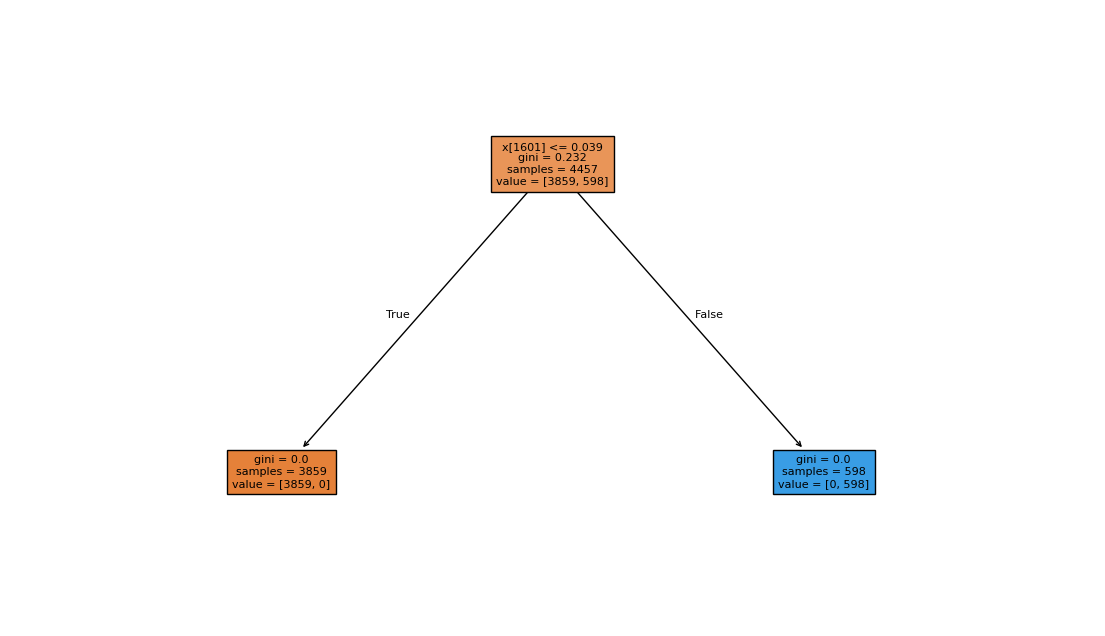

In [12]:
small_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
pipeline_small = Pipeline([('tfidf', TfidfVectorizer(max_features=2000)), ('clf', small_tree)])
pipeline_small.fit(X_train, y_train)

clf_small = pipeline_small.named_steps['clf']
plt.figure(figsize=(14,8))
plot_tree(clf_small, filled=True, max_depth=3, fontsize=8)
plt.show()


In [13]:
joblib.dump(pipe_rf, "models/rf_pipeline.joblib")

# later, in your web app
model = joblib.load("models/rf_pipeline.joblib")
pred = model.predict(["Please reset my password","Congratulations, you've won a lottery!","Can you please send me ticket ID"] )
print(pred)  # 0 or 1

[0 0 1]


              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       966
        spam       1.00      0.97      0.98       149

    accuracy                           1.00      1115
   macro avg       1.00      0.98      0.99      1115
weighted avg       1.00      1.00      1.00      1115



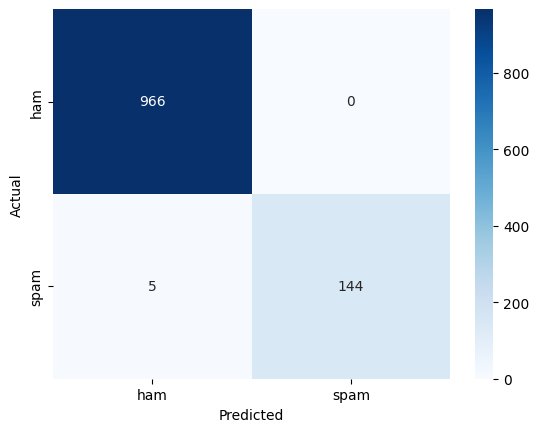

In [14]:

import seaborn as sns

# Predictions
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=["ham", "spam"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Pretty plot
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["ham", "spam"],
            yticklabels=["ham", "spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
